# AI for Chemistry: Step-by-Step Python and Jupyter Guide

This notebook is for your first class. It walks slowly, explains every step, and uses chemistry examples throughout.

### How to use this notebook
- Click any cell, then press **Shift+Enter** to run it.
- Blue left border means **edit mode**. Gray left border means **command mode**. Press **Esc** to switch to command mode, **Enter** to edit.
- Common shortcuts in command mode: **A** adds a cell above, **B** adds below, **M** makes a Markdown cell, **Y** makes a Code cell, **DD** deletes the current cell.
- If you see an error, read the last two lines of the red text. They usually tell you what went wrong.

### What we will cover
1. Jupyter basics and why scientists use notebooks
2. Python as a calculator using chemistry quantities
3. Variables and types
4. Lists, dictionaries, and loops for organizing data from the lab
5. Writing small functions to reuse work
6. Plotting with matplotlib, error bars, and simple curve fits
7. A first AI model: linear regression for a calibration curve
8. A bonus mini project on stoichiometry and pH
9. Reading simple CSV data with pandas
10. Practice tasks and common mistakes


## 0. What makes notebooks useful to chemists

- You can mix text, math, code, and plots in one place.
- You can show how a result was obtained, not only the final number.
- You can re-run the same workflow on new data from a later experiment.

**Tip**: Save often. Use the save icon or press **Ctrl+S** (Windows) or **Cmd+S** (Mac).


## 1. Python as a calculator with chemistry constants

We start with a few constants and simple arithmetic. Treat this like a smart calculator that remembers names.


In [1]:
# Avogadro constant (exact by definition since 2019, mol^-1)
NA = 6.022_140_76e23

# Gas constant in J/(mol*K)
R = 8.314462618

# Example: how many particles are in 0.020 mol
moles = 0.020
particles = moles * NA
print("Particles in", moles, "mol:", particles)

# Example: ideal gas PV = nRT  ->  V = nRT / P
# 1.00 mol at 298 K and 1.00 atm (convert atm to Pa: 1 atm = 101325 Pa)
P_atm = 1.00
P_Pa = P_atm * 101_325
n = 1.00
T = 298.0
V_m3 = n * R * T / P_Pa
V_L = V_m3 * 1000.0
print("Molar volume estimate at 298 K and 1 atm:", V_L, "L")


Particles in 0.02 mol: 1.204428152e+22
Molar volume estimate at 298 K and 1 atm: 24.453095091675305 L


**Step-by-step**
1. We created names `NA` and `R` to store constants.
2. We computed a count of particles by multiplying `moles` and `NA`.
3. We rearranged the ideal gas law to compute volume in cubic meters, then converted to liters.


## 2. Variables, types, and comments

- A variable is a name that points to a value.
- The `#` sign starts a comment.
- Use `type(x)` to see what kind of value `x` is.


In [2]:
sample_name = "Sodium chloride solution"   # text is called a string
mass_g = 5.000                               # a float is a decimal number
count = 3                                    # an integer is a whole number
is_clear = True                              # a boolean is True or False

print(type(sample_name), type(mass_g), type(count), type(is_clear))

# The print function can show multiple values separated by commas
print("Sample:", sample_name, "Mass [g]:", mass_g, "Replicates:", count, "Clear:", is_clear)


<class 'str'> <class 'float'> <class 'int'> <class 'bool'>
Sample: Sodium chloride solution Mass [g]: 5.0 Replicates: 3 Clear: True


### Formatting output
`f-strings` make readable lines. Place names inside `{}`.


In [3]:
molar_mass_NaCl = 58.44   # g/mol, approximate
moles_NaCl = mass_g / molar_mass_NaCl
print(f"{mass_g:.3f} g NaCl is {moles_NaCl:.4f} mol")

5.000 g NaCl is 0.0856 mol


## 3. Lists, dictionaries, and loops

- A **list** is an ordered collection.
- A **dictionary** maps a key to a value. Great for a tiny periodic table.
- A **loop** repeats the same action for each item.


In [4]:
# A tiny periodic table for this class (g/mol). Values are rounded for teaching.
atomic_mass = {
    "H": 1.008, "C": 12.011, "N": 14.007, "O": 15.999,
    "Na": 22.990, "Mg": 24.305, "Al": 26.982, "Si": 28.085,
    "P": 30.974, "S": 32.06, "Cl": 35.45, "K": 39.098, "Ca": 40.078,
    "Fe": 55.845, "Cu": 63.546, "Zn": 65.38
}

elements = ["H", "C", "N", "O"]  # a list
for e in elements:
    print(e, "->", atomic_mass[e])

H -> 1.008
C -> 12.011
N -> 14.007
O -> 15.999


### Practice
- Add `"F": 18.998` to `atomic_mass`. Print the mass.
- Create a list of three elements you used last week and loop over them.


## 4. Parsing simple chemical formulas

We will write a small function to compute molar mass from a formula like `H2O` or `Ca(OH)2` or `CuSO4·5H2O`. This is a good place to see how loops and dictionaries help us.


In [5]:
import re

# Pattern finds element symbols, optional integer count, and handles simple parentheses and dot hydrates.
# This parser is meant for teaching and covers many common cases. It is not a full chemistry parser.
def molar_mass(formula, masses=atomic_mass):
    # Handle dot hydrates like CuSO4·5H2O or CuSO4.5H2O
    parts = re.split(r"[·\.]", formula)
    total = 0.0
    for part in parts:
        # If the part starts with a number, it is a multiplier for a group, like 5H2O
        m = re.match(r"^(\d+)(.*)$", part.strip())
        multiplier = 1
        sub = part
        if m:
            multiplier = int(m.group(1))
            sub = m.group(2)

        total += multiplier * _mass_with_parentheses(sub, masses)
    return total

def _mass_with_parentheses(formula, masses):
    # Resolve parentheses by recursion, e.g., Ca(OH)2
    # Find innermost (...)k patterns and replace them with repeated groups
    while True:
        m = re.search(r"\(([A-Za-z0-9]+)\)(\d+)", formula)
        if not m:
            break
        group, k = m.group(1), int(m.group(2))
        # Replace "(group)k" with group repeated k times conceptually
        expanded = "".join([group] * k)
        formula = formula[:m.start()] + expanded + formula[m.end():]

    # Now parse simple symbol + optional count
    tokens = re.findall(r"([A-Z][a-z]?)(\d*)", formula)
    if not tokens:
        raise ValueError(f"Could not understand: {formula}")
    s = 0.0
    for sym, num in tokens:
        if sym not in masses:
            raise KeyError(f"Unknown element: {sym}")
        n = int(num) if num else 1
        s += masses[sym] * n
    return s

# Try a few examples
for f in ["H2O", "CO2", "NaCl", "C6H12O6", "Ca(OH)2", "CuSO4·5H2O"]:
    print(f, "->", round(molar_mass(f), 3), "g/mol")

H2O -> 18.015 g/mol
CO2 -> 44.009 g/mol
NaCl -> 58.44 g/mol
C6H12O6 -> 180.156 g/mol
Ca(OH)2 -> 74.092 g/mol
CuSO4·5H2O -> 249.677 g/mol


**Step-by-step**
1. Split on `·` or `.` to support hydrates.
2. Expand parentheses by repeating the inner group.
3. Use a pattern to read each element symbol and its count.
4. Look up each symbol in our dictionary and accumulate the mass.


## 5. Reusable functions for common lab math

We will create small functions to convert between grams, moles, and particles. Functions help you avoid repeating code.


In [6]:
NA = 6.022_140_76e23  # redefine here so this cell works alone if needed

def grams_to_moles(mass_g, formula):
    mm = molar_mass(formula)
    return mass_g / mm

def moles_to_particles(moles):
    return moles * NA

def grams_to_particles(mass_g, formula):
    return moles_to_particles(grams_to_moles(mass_g, formula))

print("10.0 g of CO2 in mol:", round(grams_to_moles(10.0, "CO2"), 5))
print("Particles in 10.0 g CO2:", "{:.3e}".format(grams_to_particles(10.0, "CO2")))

10.0 g of CO2 in mol: 0.22723
Particles in 10.0 g CO2: 1.368e+23


## 6. Control flow with `if`

We will classify a solution as dilute or concentrated by a simple rule, then print a message.


In [7]:
concentration_M = 0.025
if concentration_M < 0.010:
    print("Dilute sample")
elif concentration_M < 0.100:
    print("Moderate sample")
else:
    print("Concentrated sample")

Moderate sample


## 7. Loops to build a small table

Let us tabulate masses, moles, and estimated particle counts for a list of sample masses.


In [8]:
masses_g = [1.0, 2.5, 5.0, 10.0]
formula = "H2O"
print("mass_g\tmoles\tparticles")
for m in masses_g:
    n = grams_to_moles(m, formula)
    N = moles_to_particles(n)
    print(f"{m:.2f}\t{n:.5f}\t{N:.3e}")

mass_g	moles	particles
1.00	0.05551	3.343e+22
2.50	0.13877	8.357e+22
5.00	0.27755	1.671e+23
10.00	0.55509	3.343e+23


## 8. Plotting with matplotlib

We will generate synthetic calibration data for a dye using the idea behind Beer Lambert law. Then we will plot the data and the fitted line.


slope: 0.43314139671172774
intercept: -0.010005728976989658
R^2: 0.999271611664202


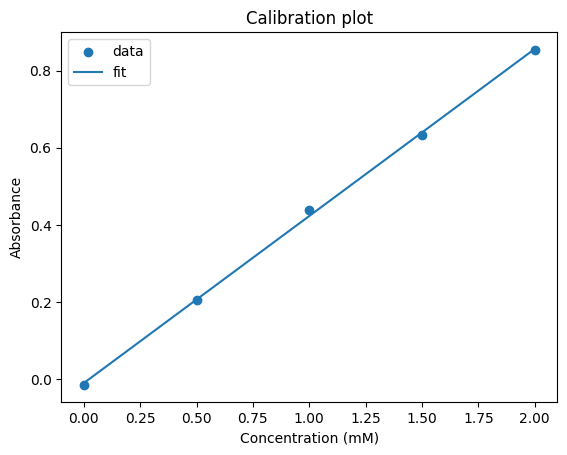

In [9]:
# If matplotlib is missing in your environment, you can install it using pip in a terminal.
# Inside a notebook you could run: !pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Make a small dataset: concentration in mM, absorbance unitless
c = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
true_slope = 0.42
rng = np.random.default_rng(123)
A = true_slope * c + rng.normal(0, 0.015, size=c.size)  # add small noise

# Fit a straight line using numpy
coef = np.polyfit(c, A, 1)
slope, intercept = coef
fit_A = slope * c + intercept

# Compute R^2
ss_res = np.sum((A - fit_A)**2)
ss_tot = np.sum((A - np.mean(A))**2)
r2 = 1 - ss_res/ss_tot

print("slope:", slope)
print("intercept:", intercept)
print("R^2:", r2)

plt.figure()
plt.scatter(c, A, label="data")
plt.plot(c, fit_A, label="fit")
plt.xlabel("Concentration (mM)")
plt.ylabel("Absorbance")
plt.title("Calibration plot")
plt.legend()
plt.show()

### Error bars

Real data has variability. We can show one standard deviation as error bars if we have replicates.


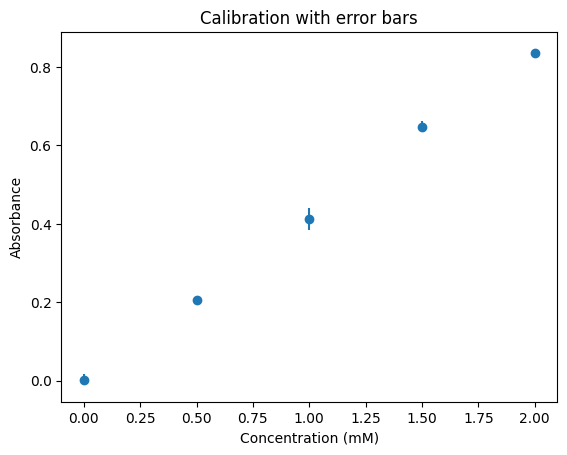

In [10]:
# Create 3 replicates at each concentration
c_rep = np.repeat(c, 3)
A_rep = true_slope * c_rep + rng.normal(0, 0.02, size=c_rep.size)

# Compute mean and std at each concentration
means = [A_rep[c_rep == x].mean() for x in c]
stds  = [A_rep[c_rep == x].std(ddof=1) for x in c]

plt.figure()
plt.errorbar(c, means, yerr=stds, fmt='o')
plt.xlabel("Concentration (mM)")
plt.ylabel("Absorbance")
plt.title("Calibration with error bars")
plt.show()

## 9. A first AI model for calibration

We will let a linear regression model learn the mapping from concentration to absorbance. Then we will invert the line to estimate concentration from a new absorbance.


In [11]:
# If scikit-learn is missing: !pip install scikit-learn
from sklearn.linear_model import LinearRegression
import numpy as np

# Use clean pairs for teaching
c_train = np.array([0.0, 0.5, 1.0, 1.5, 2.0]).reshape(-1, 1)
A_train = np.array([0.00, 0.22, 0.43, 0.64, 0.84])

model = LinearRegression()
model.fit(c_train, A_train)

print("slope:", model.coef_[0])
print("intercept:", model.intercept_)
print("R^2 on training:", model.score(c_train, A_train))

# Predict concentration from a new absorbance A by rearranging y = m x + b -> x = (y - b)/m
A_unknown = 0.50
pred_c = (A_unknown - model.intercept_) / model.coef_[0]
print("Predicted concentration for A=0.50:", float(pred_c), "mM")

ModuleNotFoundError: No module named 'sklearn'

### Train and test split

We split data into train and test to see how the model performs on new points.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

rng = np.random.default_rng(7)
c_all = np.linspace(0, 2.0, 25).reshape(-1, 1)
A_all = 0.42 * c_all.squeeze() + rng.normal(0, 0.01, size=c_all.size)

c_tr, c_te, A_tr, A_te = train_test_split(c_all, A_all, test_size=0.3, random_state=0)

m = LinearRegression().fit(c_tr, A_tr)
A_pred = m.predict(c_te)
print("Test R^2:", r2_score(A_te, A_pred))
print("Test RMSE:", mean_squared_error(A_te, A_pred, squared=False))

## 10. Bonus: slight curvature and polynomial regression

Spectrometers can show curvature at high absorbance. We can model that using a polynomial of degree 2.


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

rng = np.random.default_rng(11)
c_curve = np.linspace(0, 3.0, 40).reshape(-1, 1)
# Create mild curvature: A = 0.45*c - 0.015*c^2 + noise
A_curve = 0.45*c_curve.squeeze() - 0.015*(c_curve.squeeze()**2) + rng.normal(0, 0.02, size=c_curve.size)

poly2 = make_pipeline(PolynomialFeatures(2, include_bias=False), LinearRegression())
poly2.fit(c_curve, A_curve)
A_fit = poly2.predict(c_curve)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(c_curve, A_curve, s=15, label="data")
plt.plot(c_curve, A_fit, label="quadratic fit")
plt.xlabel("Concentration")
plt.ylabel("Absorbance")
plt.title("Mild curvature example")
plt.legend()
plt.show()

## 11. Mini project: simple stoichiometry and limiting reagent

Reaction: `HCl(aq) + Na2CO3(aq) -> NaCl(aq) + H2O(l) + CO2(g)`

Balanced form: `2 HCl + Na2CO3 -> 2 NaCl + H2O + CO2`

We will compute the limiting reagent and the amount of CO2 formed given solution volumes and molarities.


In [ ]:
def limiting_reagent_HCl_Na2CO3(M_HCl, V_HCl_L, M_Na2CO3, V_Na2CO3_L):
    # Stoichiometric coefficients
    nu_HCl = 2
    nu_Na2CO3 = 1
    nu_CO2 = 1

    n_HCl = M_HCl * V_HCl_L
    n_Na2CO3 = M_Na2CO3 * V_Na2CO3_L

    # Compare required ratios: n/nu
    avail_HCl = n_HCl / nu_HCl
    avail_Na2CO3 = n_Na2CO3 / nu_Na2CO3

    # Limiting reagent is the smaller of availabilities
    if avail_HCl < avail_Na2CO3:
        limiting = "HCl"
        extent = avail_HCl
    else:
        limiting = "Na2CO3"
        extent = avail_Na2CO3

    n_CO2 = extent * nu_CO2
    return limiting, n_CO2

limiting, n_CO2 = limiting_reagent_HCl_Na2CO3(M_HCl=0.50, V_HCl_L=0.040, M_Na2CO3=0.20, V_Na2CO3_L=0.050)
print("Limiting reagent:", limiting)
print("Moles of CO2 formed:", round(n_CO2, 4))

### Convert moles of CO2 to a gas volume estimate at room conditions

Use the ideal gas law again.


In [ ]:
R = 8.314462618    # J/(mol*K)
T = 298.0           # K
P = 101_325         # Pa

V_m3 = n_CO2 * R * T / P
print("Volume of CO2 at 298 K and 1 atm:", V_m3*1000, "L")

## 12. pH estimator for a strong acid

For a strong monoprotic acid at 25 C, assume full dissociation. Then `[H+] = c` and `pH = -log10([H+])`.


In [ ]:
import numpy as np

def pH_strong_acid(c_M):
    c = float(c_M)
    H = max(c, 1e-14)
    return -np.log10(H)

for c in [1e-1, 1e-2, 1e-3, 1e-4]:
    print(f"c = {c:.1e} M -> pH = {pH_strong_acid(c):.2f}")

### Plot the estimate on a log x-axis


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

c_grid = np.logspace(-6, 0, 100)
pH = [-np.log10(max(c, 1e-14)) for c in c_grid]

plt.figure()
plt.semilogx(c_grid, pH)
plt.xlabel("Acid concentration (M)")
plt.ylabel("Estimated pH")
plt.title("Strong acid pH estimate")
plt.show()

## 13. Reading a simple CSV with pandas

Datasets often arrive as CSV files. We will create a small CSV in memory, read it with pandas, and compute a fit. In your work you would load your real file from disk.


In [ ]:
# If pandas is missing: !pip install pandas
import io, pandas as pd, numpy as np

csv_text = """concentration_mM,absorbance
0.0,0.000
0.5,0.210
1.0,0.415
1.5,0.625
2.0,0.825
"""

df = pd.read_csv(io.StringIO(csv_text))
df

In [ ]:
# Fit a line using numpy on the DataFrame columns
coef = np.polyfit(df["concentration_mM"].values, df["absorbance"].values, 1)
slope, intercept = coef
print("slope:", slope, "intercept:", intercept)

# Predict output for an unknown
A_unknown = 0.50
c_est = (A_unknown - intercept) / slope
print("Estimated concentration for A=0.50:", c_est, "mM")

## 14. Common mistakes and how to fix them

- **NameError: name 'something' is not defined**  
  You tried to use a variable before creating it. Run the cell where it was defined or fix the name.

- **SyntaxError**  
  Python could not read the code. Check quotes, parentheses, and colons.

- **KeyError** from the formula function  
  You used an element symbol that is not in `atomic_mass`. Add the symbol to the dictionary.

- **TypeError** mixing strings and numbers  
  Convert types as needed. For example use `float("3.5")` or `str(3.5)`.


## 15. Practice tasks

Try these now. You can duplicate cells if you want a template.

1. Add `"Br": 79.904` and `"I": 126.904` to `atomic_mass` then compute the molar mass of KI and NaBr.
2. Use `molar_mass("Ca(OH)2")` and compute the grams needed to prepare 250.0 mL of a 0.0500 M solution.
3. Create your own calibration data at 0.25 mM intervals from 0 to 2.0 mM, add noise with `rng.normal`, fit a line, and report slope, intercept, and R².
4. Write a function `density_to_mass(density_g_per_mL, volume_mL)` and use it to compute grams of ethanol given 15.0 mL and density 0.789 g/mL.
5. Challenge: Modify the formula parser to support nested parentheses like `Al2(SO4)3` without expanding by repetition. Hint: use a stack.


## 16. Next steps

- Read and write CSV files from your instrument folder.
- Move calculations into functions so you can test them.
- Explore polynomial and regularized regression for curved calibration data.
- Try simple molecular descriptors and predict a property with a regression model.
